# Sentiment Analysis

In [44]:
import multiprocessing
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score

def get_data_frame():
    dataset = pd.read_csv('labelled.csv')
    
    #print(dataset)

    # get positive class
    class_positive = dataset[dataset['Label'] == '__label__2']

    # get negative class
    class_negative = dataset[dataset['Label'] == '__label__1']

    # under sample positive class randomly with the size of negative class
    positive_under = class_positive.sample(class_negative.shape[0],replace=True)

    # concatenate negative and new under sampled positive class
    df_test_under = pd.concat([positive_under, class_negative], axis=0)

    return df_test_under

def split_train_test(data):
    
    # creating the feature matrix
    matrix = CountVectorizer(max_features=1000, stop_words="english")
    #print(data.iloc[:, -1])
    X = matrix.fit_transform(data['Review'].values.astype('U')).toarray()
    y_tmp = data.iloc[:, 0]
    
    y = []
    for idx, val in y_tmp.iteritems():
        if val == '__label__2':
            y.append("positive")
        elif val == '__label__1':
            y.append("negative")

    # split train and test data
    return train_test_split(X, y,test_size=0.20)


def y_to_float(y):
    y_float = []
    #print(y)
    for val in y:
        if val == "positive":
            y_float.append(1)
        elif val == "negative":
            y_float.append(0)
    #print(y_float)
    return y_float


def run_gaussianNB(X_train, X_test, y_train, y_test):
    y_train_f = y_to_float(y_train)
    #print(y_train_f)
    y_test_f = y_to_float(y_test)

    # Naive Bayes
    classifier = GaussianNB()
    classifier.fit(X_train, y_train_f)

    # predict class
    y_pred = classifier.predict(X_test)

    # Confusion matrix
    print("GAUSSIAN NAIVE BAYES")
    print(confusion_matrix(y_test_f, y_pred))
    print(classification_report(y_test_f, y_pred))
    print(accuracy_score(y_test_f, y_pred))


def run_multinomialNB(X_train, X_test, y_train, y_test):
    y_train_f = y_to_float(y_train)
    y_test_f = y_to_float(y_test)
    tf_transformer = TfidfTransformer().fit_transform(X_train)
    #print(tf_transformer.shape)
    classifier = MultinomialNB()
    classifier.fit(tf_transformer, y_train_f)
    
    y_pred = classifier.predict(X_test)
    
    #filename = 'sentiment_analysis_multinomialNB_model.sav'
    #pickle.dump(classifier, open(filename, "wb"))

    # Confusion matrix
    print("MULTINOMIAL NAIVE BAYES")
    print(confusion_matrix(y_test_f, y_pred))
    print(classification_report(y_test_f, y_pred))
    print(accuracy_score(y_test_f, y_pred))

def run_bernoulliNB(X_train, X_test, y_train, y_test):
    y_train_f = y_to_float(y_train)
    y_test_f = y_to_float(y_test)

    #classifier = BernoulliNB()
    #classifier.fit(X_train, y_train_f) 

    y_pred = classifier.predict(X_test)
    #print(X_test)
    
    filename = 'sentiment_analysis_bernoulliNB_model.sav'
    pickle.dump(classifier, open(filename, "wb"))

    # Confusion matrix
    print("BERNOULLI NAIVE BAYES")
    print(confusion_matrix(y_test_f, y_pred))
    print(classification_report(y_test_f, y_pred))
    print(accuracy_score(y_test_f, y_pred))

if __name__ == "__main__":
    data = get_data_frame()
    X_train, X_test, y_train, y_test = split_train_test(data)
    #print(y_test)
    #run_gaussianNB(X_train, X_test, y_train, y_test)
    run_multinomialNB(X_train, X_test, y_train, y_test)
    #run_bernoulliNB(X_train, X_test, y_train, y_test)

MULTINOMIAL NAIVE BAYES
[[ 92  17]
 [ 10 101]]
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       109
           1       0.86      0.91      0.88       111

    accuracy                           0.88       220
   macro avg       0.88      0.88      0.88       220
weighted avg       0.88      0.88      0.88       220

0.8772727272727273


# Sentiment Analysis (Using Pipeline) 

In [76]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
#from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve, average_precision_score
import pickle

'''
model = Pipeline([('vect', TfidfVectorizer()), 
                     ('clf', MultinomialNB()) ])
model = Pipeline([ ('vect', CountVectorizer(stop_words='english')),
                  ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB()) ])
'''

df = pd.read_csv('labelled1.csv')
#df.head()

X=df.drop(['Label'],axis=1)
#print(X.head())

df['Label'].replace({"__label__1 ": "__label__1", "__label__2 ": "__label__2"}, inplace=True)
df['Label'].replace({"__label__1": 0, "__label__2": 1}, inplace=True)
y=df['Label']
#print(y.head())

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.15)

vt = Pipeline([ ('vect', CountVectorizer(max_features=1000, stop_words='english')),
                  ('tfidf', TfidfTransformer()),
                 ('clf', MultinomialNB()) ])
#print(vt)
vt.fit(X_train.transpose().apply(lambda x: ' '.join(x)),y_train)

prediction = vt.predict(X_test.transpose().apply(lambda x: ' '.join(x)))

#filename = 'finalized_model.sav'
#pickle.dump(vt, open(filename, "wb"))

print(accuracy_score(y_test, prediction))
print(classification_report(y_test, prediction))
#print(set(y_test) - set(prediction))
print(confusion_matrix(y_test, prediction))


0    1
1    0
2    1
3    1
4    0
Name: Label, dtype: int64
0.8191489361702128
              precision    recall  f1-score   support

           0       0.86      0.79      0.82        99
           1       0.78      0.85      0.82        89

    accuracy                           0.82       188
   macro avg       0.82      0.82      0.82       188
weighted avg       0.82      0.82      0.82       188

[[78 21]
 [13 76]]


In [73]:
import sklearn.metrics as metrics

preds = prediction
fpr,tpr,threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr,tpr)


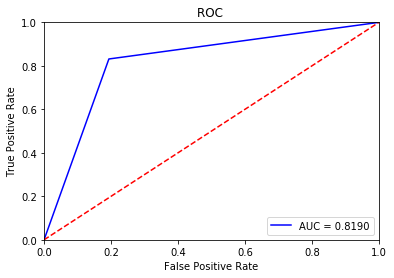

In [75]:
import matplotlib.pyplot as plt

plt.title("ROC ")
plt.plot(fpr,tpr, 'b', label='AUC = %0.4f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

# Saving the model

In [64]:
filename = 'finalized_model.sav'
pickle.dump(vt, open(filename, "wb"))

# Predicting using pipeline model

In [ ]:
import pickle
import pandas as pd
import numpy as np

df = pd.read_csv('load_the_file_with_data')
#print(df.head())
loaded_model = pickle.load(open('finalized_model.sav', 'rb'))
input_list = df['Review Body']
print(input_list.shape)
result = loaded_model.predict(input_list)
#print(np.unique(result,return_counts=True))

df['SENTIMENT'] = result
df["SENTIMENT"].replace({"__label__1": "0", "__label__2": "1"}, inplace=True)
#print(df['SENTIMENT'][:100])

print(df.head())

# Predicting using the other model

In [ ]:
import pickle
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pandas as pd
import numpy as np


df = pd.read_csv('load_the_file_with_data')
#print(df['Review Body'])
loaded_model = pickle.load(open('sentiment_analysis_multinomialNB_model.sav', 'rb'))
#input_list = df['REVIEW_TEXT']
    
matrix = CountVectorizer(max_features=1000, stop_words="english")
input_list = matrix.fit_transform(df['Review Body'].values.astype('U')).toarray()
print(input_list.shape)
result = loaded_model.predict(TfidfTransformer().fit_transform(input_list))
#print(np.unique(result,return_counts=True))
#print(result[:100])
df['SENTIMENT'] = result
print(df.head())